## Vehicle Detection Project
**Douglas Wirtz**

**February 27th, 2017**

---
The goals / steps of this project are the following:

**Vehicle Detection Project**

1. Import dependencies and functions
2. Read in dataset images and process for visualization
3. Explore image features
4. Train a classifier
5. Apply classifier to predict vehicle detection in test images
6. Run classifier pipeline on project video
---

### 1. Import dependencies and functions

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from scipy.ndimage.measurements import label
import os
import time
import glob
import numpy as np
import cv2
import glob
%matplotlib inline

# Read in images given a path to the image
def read_images(images):
    load = []
    for img in images:
        load.append(mpimg.imread(img))
    return load

# Double the dataset by appending flipped images
def flip_append(images):
    images_with_flip = []
    for i in images:
        img = np.fliplr(i)
        images_with_flip.append(i)
        images_with_flip.append(img)
    return images_with_flip#np.concatenate((images, images_flipped), axis=0)

# Correct for .PNG scaling
def fix_scale(images):
    fix_scale = []
    for i in images:
        fix_scale.append(i*255)
    return fix_scale

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256), vis_hist=False):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    if vis_hist == True:
        # Generating bin centers
        bin_edges = channel1_hist[1]
        bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
        # Return the individual histograms, bin_centers and feature vector
        return channel1_hist, channel2_hist, channel3_hist, bin_centers, hist_features
    else:
        # Return histogram features
        return hist_features

# Define a function to compute binned color features  
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        elif color_space == 'GRAY':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=True, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=False, feature_vector=feature_vec)
        return features

# Define a function to return the features of a single image
def single_img_features(img, color_space='RGB', spatial_size=(32, 32), hist_bins=32, orient=9, pix_per_cell=8, 
                        cell_per_block=2, hog_channel=0, spatial_feat=True, hist_feat=True, hog_feat=True):    
    # Define an empty list to receive features
    img_features = []
    # Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        elif color_space == 'GRAY':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else: feature_image = np.copy(img)      
    # Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Append features to list
        img_features.append(spatial_features)
    # Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins, vis_hist=False)
        # Append features to list
        img_features.append(hist_features)
    # Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], orient, pix_per_cell, 
                                                     cell_per_block, vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, pix_per_cell, 
                                            cell_per_block, vis=False, feature_vec=True)
        # Append features to list
        img_features.append(hog_features)

    # Return concatenated array of features
    return np.concatenate(img_features)

# Define a function to return the features of a list of images
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32), hist_bins=32, orient=9, pix_per_cell=8, 
                     cell_per_block=2, hog_channel=0, spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        #image = mpimg.imread(file)
        image = file
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
            elif color_space == 'GRAY':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            # Apply bin_spatial()
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins, vis_hist=False)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                   spatial_size=(32, 32), hist_bins=32, 
                   hist_range=(0, 256), orient=9, 
                   pix_per_cell=8, cell_per_block=2, 
                   hog_channel=0, spatial_feat=True, 
                   hist_feat=True, hog_feat=True):

    # Create an empty list to receive positive detection windows
    on_windows = []
    # Iterate over all windows in the list
    for window in windows:
        # Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        # Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        # Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        # Predict using your classifier
        prediction = clf.predict(test_features)
        # If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    # Return windows for positive detections
    return on_windows

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                 xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-nx_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Add heat to positive window results
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    # Return updated heatmap
    return heatmap

# Apply a threshold to remove false positives
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

# Draw tight box around labeled 'hot' zones
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

### 2. Read in dataset images and process for visualization

In [2]:
# Read in images of cars and non-cars
cars_path = glob.glob('vehicles/*/*.png')
noncars_path = glob.glob('non-vehicles/*/*.png')
cars = read_images(cars_path)
noncars = read_images(noncars_path)
print('Number of cars: ', len(cars))
print('Number of non-cars: ', len(noncars))
# Double the dataset by appending flipped images
cars2x = flip_append(cars)
noncars2x = flip_append(noncars)
# Correct for .png scaling
cars_scaled = fix_scale(cars2x)
noncars_scaled = fix_scale(noncars2x)
print('Doubling dataset with flipped images...')
print('Number of cars: ', len(cars2x))
print('Number of non-cars: ', len(noncars2x))

Number of cars:  8792
Number of non-cars:  8968
Doubling dataset with flipped images...
Number of cars:  17584
Number of non-cars:  17936


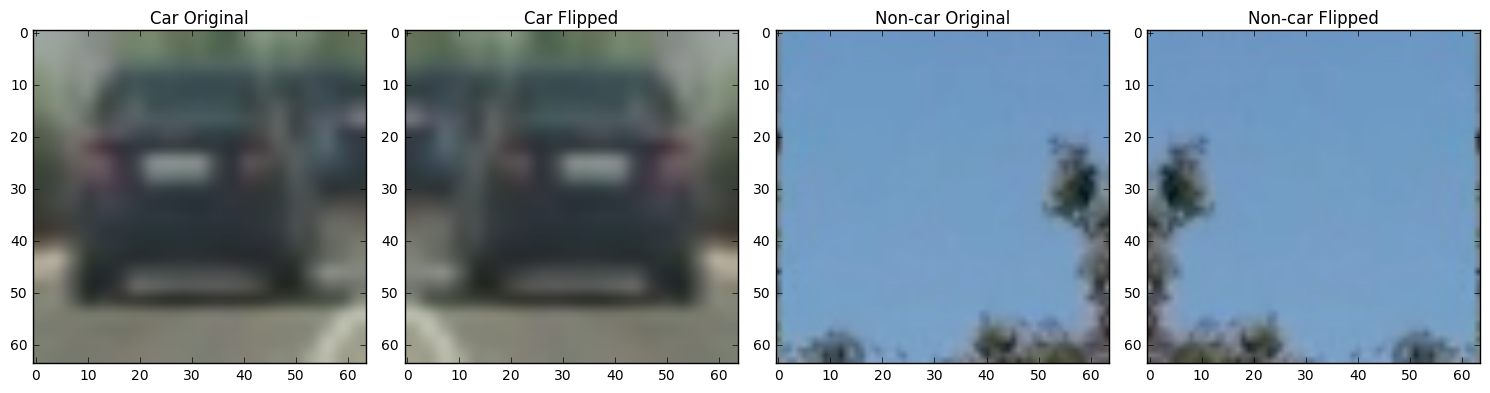

In [3]:
# Show example of car/non-car and its flipped image
fig = plt.figure(figsize=(15,5))
plt.subplot(141)
plt.imshow(cars2x[0])
plt.title('Car Original')
plt.subplot(142)
plt.imshow(cars2x[1])
plt.title('Car Flipped')
plt.subplot(143)
plt.imshow(noncars2x[0])
plt.title('Non-car Original')
plt.subplot(144)
plt.imshow(noncars2x[1])
plt.title('Non-car Flipped')
fig.tight_layout()

### 3. Explore image features

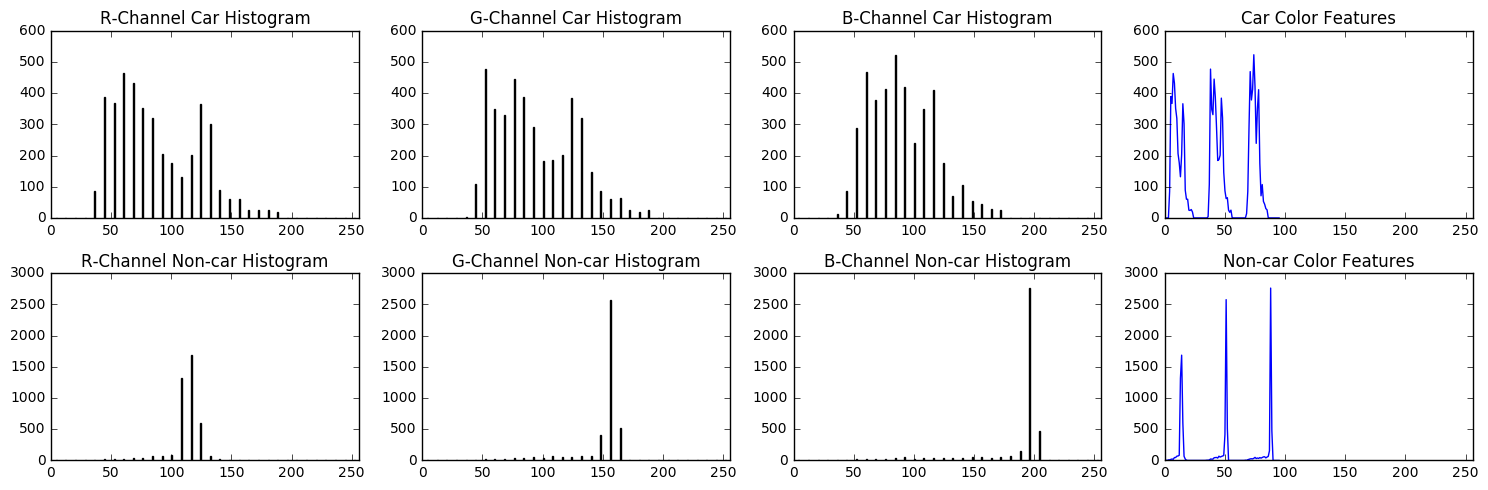

In [4]:
# Visulize the color channel features given an RGB image
# Using the original car/non-car image from the previous code block
img1 = cars_scaled[0]
img2 = noncars_scaled[0]
rh1, gh1, bh1, bincen1, feature_col1 = color_hist(img1, nbins=32, bins_range=(0, 256), vis_hist=True)
rh2, gh2, bh2, bincen2, feature_col2 = color_hist(img2, nbins=32, bins_range=(0, 256), vis_hist=True)
# Plot each channel color features
fig = plt.figure(figsize=(15,5))
plt.subplot(241)
plt.bar(bincen1, rh1[0])
plt.xlim(0, 256)
plt.ylim(0, 600)
plt.title('R-Channel Car Histogram')
plt.subplot(242)
plt.bar(bincen1, gh1[0])
plt.xlim(0, 256)
plt.ylim(0, 600)
plt.title('G-Channel Car Histogram')
plt.subplot(243)
plt.bar(bincen1, bh1[0])
plt.xlim(0, 256)
plt.ylim(0, 600)
plt.title('B-Channel Car Histogram')
plt.subplot(244)
plt.plot(feature_col1)
plt.xlim(0, 256)
plt.ylim(0, 600)
plt.title('Car Color Features')
plt.subplot(245)
plt.bar(bincen2, rh2[0])
plt.xlim(0, 256)
plt.ylim(0, 3000)
plt.title('R-Channel Non-car Histogram')
plt.subplot(246)
plt.bar(bincen2, gh2[0])
plt.xlim(0, 256)
plt.ylim(0, 3000)
plt.title('G-Channel Non-car Histogram')
plt.subplot(247)
plt.bar(bincen2, bh2[0])
plt.xlim(0, 256)
plt.ylim(0, 3000)
plt.title('B-Channel Non-car Histogram')
plt.subplot(248)
plt.plot(feature_col2)
plt.xlim(0, 256)
plt.ylim(0, 3000)
plt.title('Non-car Color Features')
fig.tight_layout()

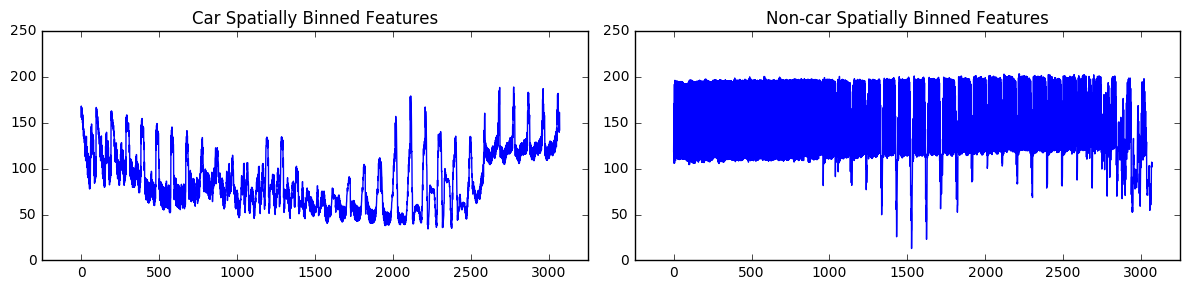

In [5]:
# Visulize the spatially binned features given an RGB image
# Using the original car/non-car image from the previous code block
feature_bin1 = bin_spatial(img1, color_space='RGB', size=(32, 32))
feature_bin2 = bin_spatial(img2, color_space='RGB', size=(32, 32))
# Plot spatially binned features
fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.plot(feature_bin1)
plt.xlim(-250, 3250)
plt.ylim(0, 250)
plt.title('Car Spatially Binned Features')
plt.subplot(122)
plt.plot(feature_bin2)
plt.xlim(-250, 3250)
plt.ylim(0, 250)
plt.title('Non-car Spatially Binned Features')
fig.tight_layout()

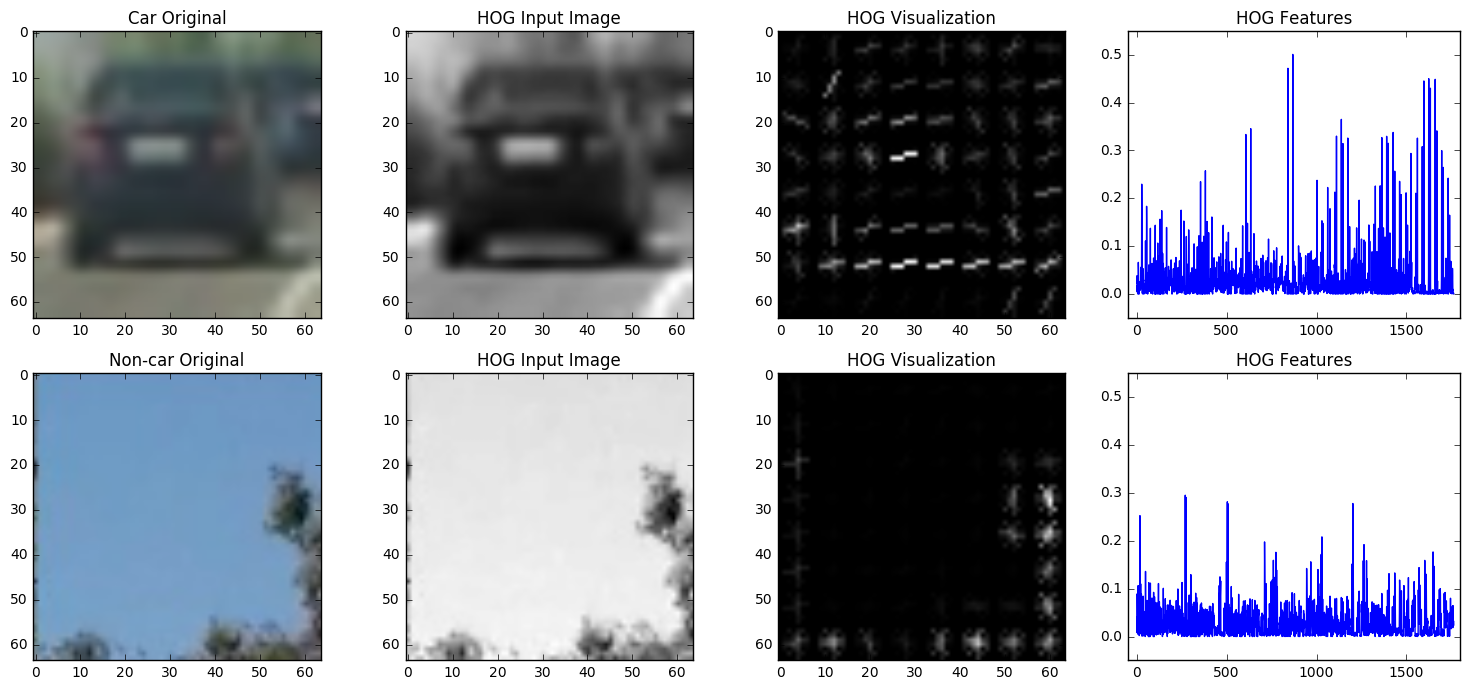

In [6]:
# Visualize the HOG features of a grayscale image
# Continuing with the original car/non-car image from the previous code block
pix_per_cell = 8
cell_per_block = 2
orient = 9
# NOTE: hog() can take a single color channel or a grayscale image
gray1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
feature_hog1, hog_image1 = get_hog_features(gray1, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
feature_hog2, hog_image2 = get_hog_features(gray2, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
# Plot HOG features of the examples
fig = plt.figure(figsize=(15,7))
plt.subplot(241)
plt.imshow(cars2x[0])
plt.title('Car Original')
plt.subplot(242)
plt.imshow(gray1, 'gray')
plt.title('HOG Input Image')
plt.subplot(243)
plt.imshow(hog_image1, 'gray')
plt.title('HOG Visualization')
plt.subplot(244)
plt.plot(feature_hog1)
plt.xlim(-50, 1800)
plt.ylim(-0.05, 0.55)
plt.title('HOG Features')
plt.subplot(245)
plt.imshow(noncars2x[0])
plt.title('Non-car Original')
plt.subplot(246)
plt.imshow(gray2, 'gray')
plt.title('HOG Input Image')
plt.subplot(247)
plt.imshow(hog_image2, 'gray')
plt.title('HOG Visualization')
plt.subplot(248)
plt.plot(feature_hog2)
plt.xlim(-50, 1800)
plt.ylim(-0.05, 0.55)
plt.title('HOG Features')
fig.tight_layout()

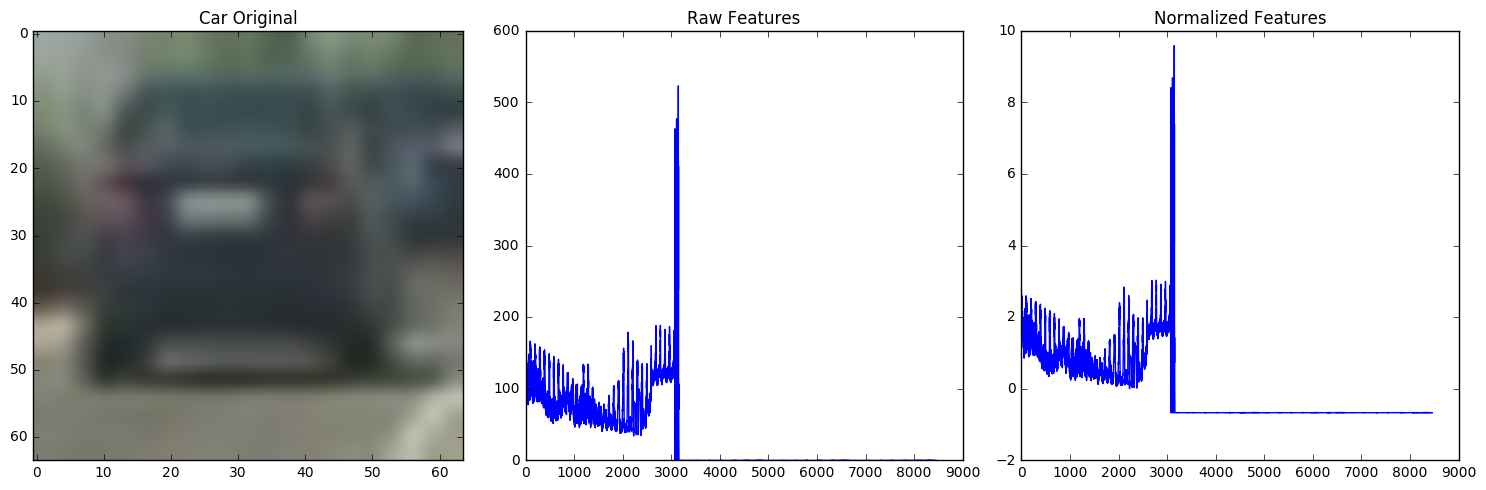

In [7]:
# Concatenate color, spatial, and HOG features of car image
# Normalize the features and plot
color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb, GRAY
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

feature_example = single_img_features(img1, color_space=color_space, 
                                      spatial_size=spatial_size, hist_bins=hist_bins, 
                                      orient=orient, pix_per_cell=pix_per_cell, 
                                      cell_per_block=cell_per_block, 
                                      hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                      hist_feat=hist_feat, hog_feat=hog_feat)

feature_example = feature_example.reshape(-1, 1)
feature_example_scaler = StandardScaler().fit(feature_example)
scaled_example = feature_example_scaler.transform(feature_example)
fig = plt.figure(figsize=(15,5))
plt.subplot(131)
plt.imshow(cars2x[0])
plt.title('Car Original')
plt.subplot(132)
plt.plot(feature_example)
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_example)
plt.title('Normalized Features')
fig.tight_layout()

### 4. Train a classifier

In [8]:
# Train a SVM classifier
color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

t = time.time()
car_features = extract_features(cars_scaled, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)

noncar_features = extract_features(noncars_scaled, color_space=color_space, 
                                   spatial_size=spatial_size, hist_bins=hist_bins, 
                                   orient=orient, pix_per_cell=pix_per_cell, 
                                   cell_per_block=cell_per_block, 
                                   hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                   hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract image features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, noncar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(noncar_features))))
# Shuffle features and labels
scaled_X, y = shuffle(scaled_X, y, random_state=18)
# Split data into randomized training and test sets
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=18)
print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

223.47 Seconds to extract image features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
105.96 Seconds to train SVC...
Test Accuracy of SVC =  0.9879
My SVC predicts:  [ 0.  1.  0.  0.  0.  0.  1.  1.  1.  0.]
For these 10 labels:  [ 0.  1.  0.  0.  0.  0.  1.  1.  1.  0.]
0.02 Seconds to predict 10 labels with SVC


### 5. Apply classifier to predict vehicle detection in test images

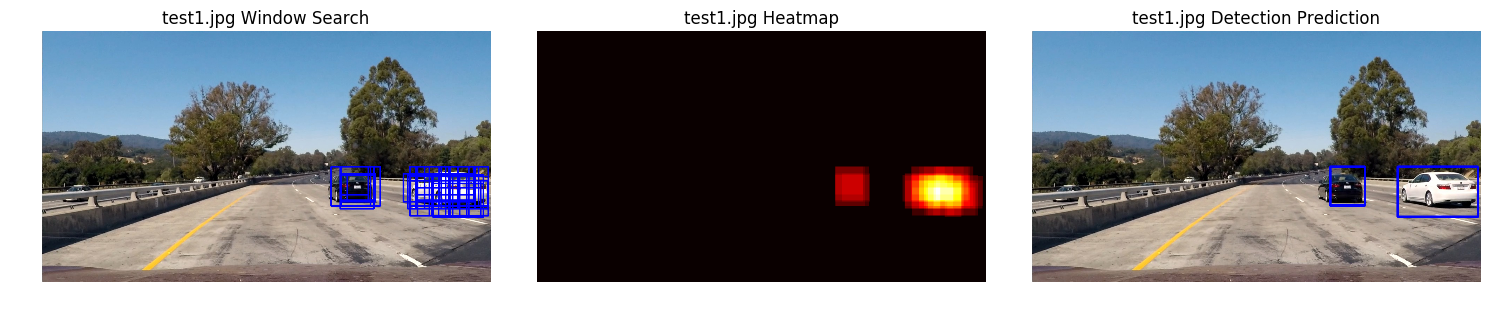

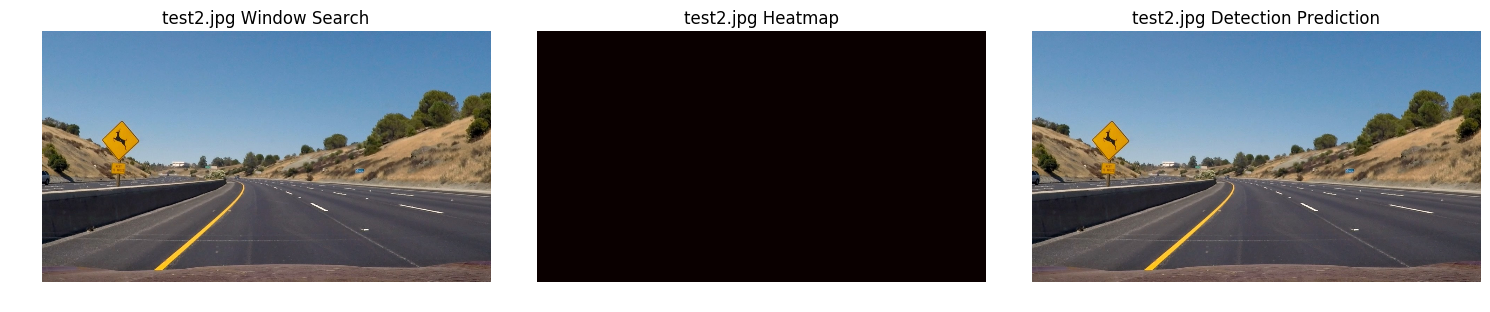

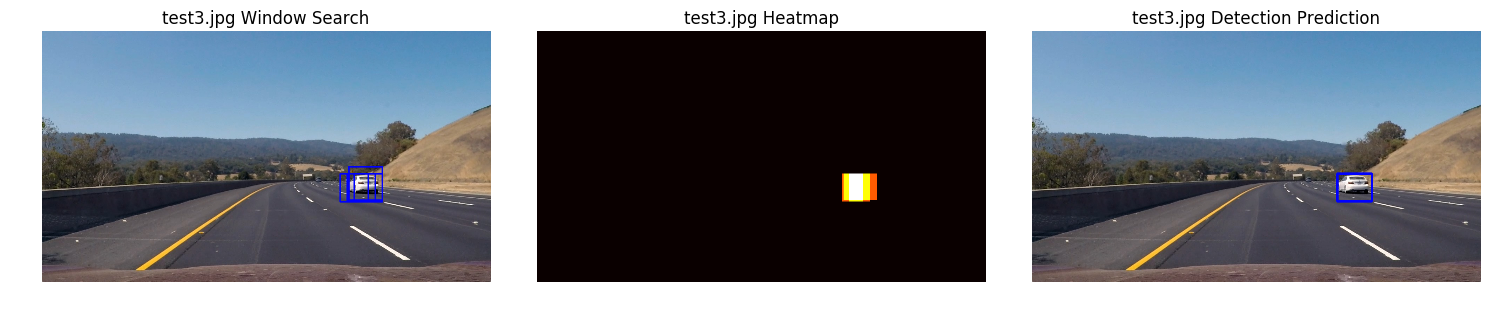

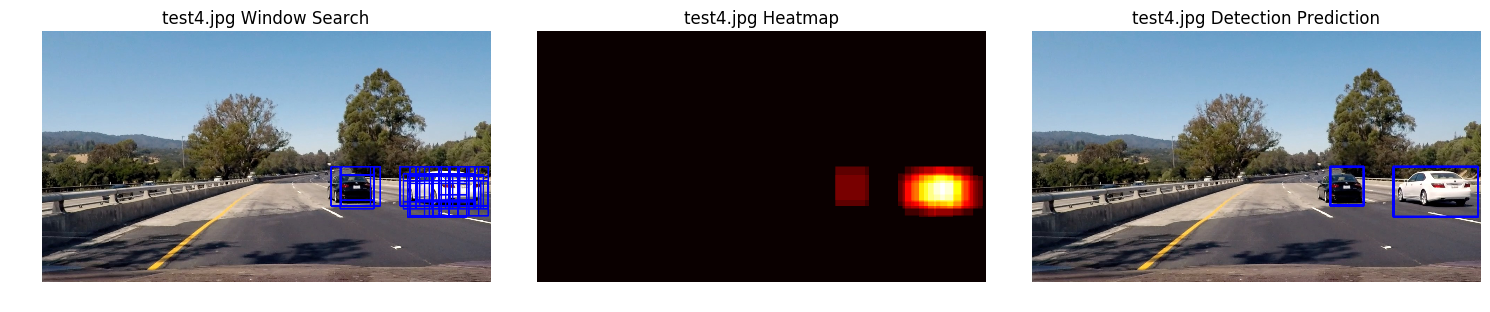

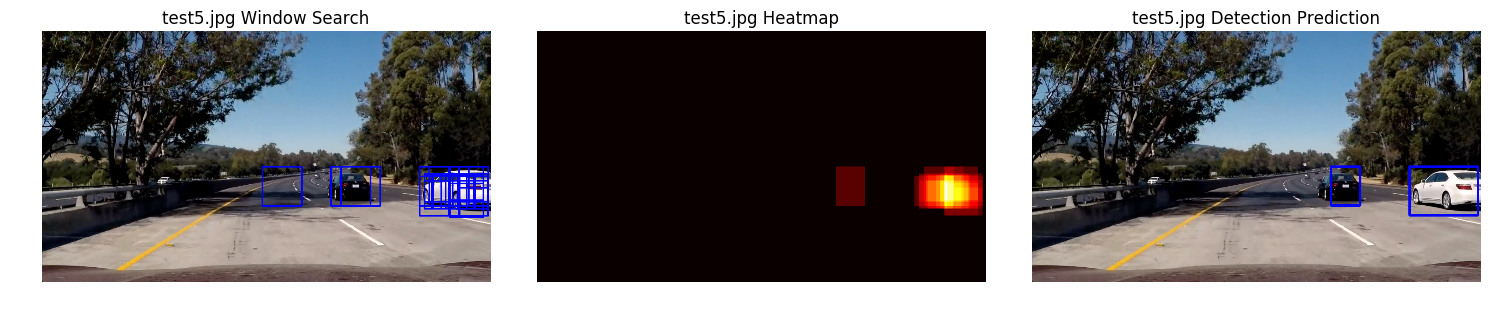

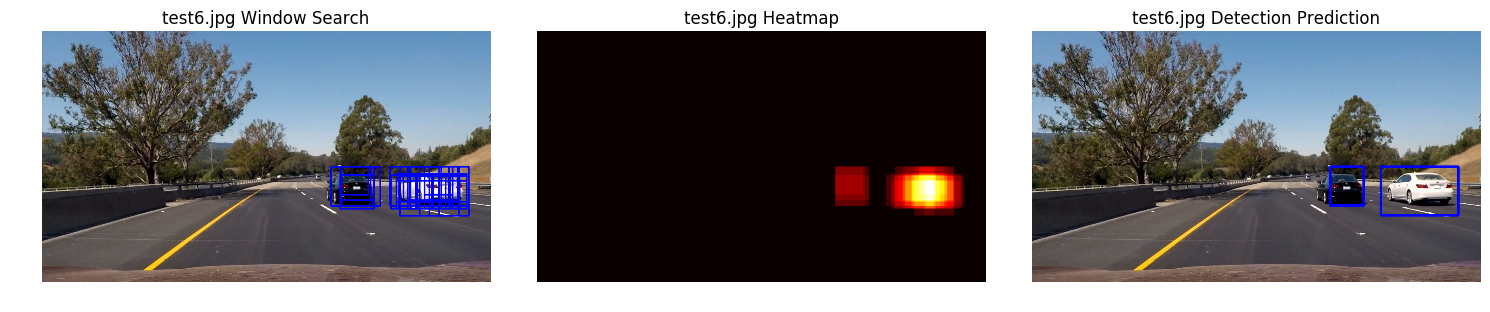

In [50]:
# Set parameters
y_start_stop = [[390, 640], [390, 600], [390, 540]] # Min and max in y to search in slide_window()
xy_window = [(112, 112), (96, 96), (80, 80)] # Set xy_window size for each search
x_start_stop = [[320, None], [850, None], [850, None]] # Min and max in x to search in slide_window()
windows = [None, None, None]
x = 1
for img in os.listdir('test_images/'):
    # Draw predicted boxes on a test image
    image = mpimg.imread('test_images/' + img)
    draw_image = np.copy(image)
    hot_windows_all = []
    for i in range(0, 3):
        windows[i] = slide_window(image, x_start_stop=x_start_stop[i], y_start_stop=y_start_stop[i], 
                                xy_window=xy_window[i], xy_overlap=(0.75, 0.75))

        hot_windows = search_windows(image, windows[i], svc, X_scaler, color_space=color_space, 
                                     spatial_size=spatial_size, hist_bins=hist_bins, 
                                     orient=orient, pix_per_cell=pix_per_cell, 
                                     cell_per_block=cell_per_block, 
                                     hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                     hist_feat=hist_feat, hog_feat=hog_feat)
        hot_windows_all.extend(hot_windows)
        window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=4)
        draw_image = np.copy(window_img)
    # Handle multiple detections and false positives on a test image
    heat = np.zeros_like(image[:, :, 0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat, hot_windows_all)   
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 1)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    plt.figure(figsize=(15, 20))
    plt.subplot(6, 3, x).set_title(img + ' Window Search')
    plt.imshow(window_img)
    plt.axis('off')
    plt.subplot(6, 3, x+1).set_title(img + ' Heatmap')
    plt.imshow(heatmap, cmap='hot')
    plt.axis('off')
    plt.subplot(6, 3, x+2).set_title(img + ' Detection Prediction')
    plt.imshow(draw_img)
    plt.axis('off')
    plt.tight_layout()
    # Save draw_img
    plt.imsave('output_images/new_' + img, draw_img)
    x += 3 

### 6. Run classifier pipeline on project video

In [53]:
# Define image processing pipeline for video
set_prev = 0
smoothing_factor = 0.2
def pipeline(image):
    global set_prev
    global heatmap_prev
    y_start_stop = [[390, 640], [390, 600], [390, 540]] # Min and max in y to search in slide_window()
    xy_window = [(112, 112), (96, 96), (80, 80)] # Set xy_window size for each search
    x_start_stop = [[320, None], [850, None], [850, None]] # Min and max in x to search in slide_window()
    windows = [None, None, None]
    hot_windows_all = []
    for i in range(0, 3):
        windows[i] = slide_window(image, x_start_stop=x_start_stop[i], y_start_stop=y_start_stop[i], 
                                  xy_window=xy_window[i], xy_overlap=(0.75, 0.75))

        hot_windows = search_windows(image, windows[i], svc, X_scaler, color_space=color_space, 
                                     spatial_size=spatial_size, hist_bins=hist_bins, 
                                     orient=orient, pix_per_cell=pix_per_cell, 
                                     cell_per_block=cell_per_block, 
                                     hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                     hist_feat=hist_feat, hog_feat=hog_feat)
        hot_windows_all.extend(hot_windows)
    heat = np.zeros_like(image[:, :, 0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat, hot_windows_all)   
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 1)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
   
    if set_prev == 0:
        set_prev = 1
        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        # Set previous heatmap to use in the next frame
        heatmap_prev = heatmap
    else:
        # Use smoothing factor to combine current and previous heatmaps
        heatmap = heatmap * (1 - smoothing_factor) + heatmap_prev * smoothing_factor
        heatmap = apply_threshold(heatmap, 2)
        # Find final boxes from combined heatmap using label function
        labels = label(heatmap)
        heatmap_prev = heatmap
        
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return draw_img

In [52]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
project_output = 'new_project_video.mp4'
clip1 = VideoFileClip('project_video.mp4')
project_clip = clip1.fl_image(pipeline)
%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video new_project_video.mp4
[MoviePy] Writing video new_project_video.mp4


100%|█████████████████████████████████████████████████████████▉| 1260/1261 [49:45<00:02,  2.31s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: new_project_video.mp4 

Wall time: 49min 46s
